In [1]:
%pip install -e ../../

Obtaining file:///home/fukai/projects/BaSiCPy
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.5 MB/s eta 0:00:00
  Building editable for BaSiCPy (pyproject.toml) ... done
  Created wheel for BaSiCPy: filename=BaSiCPy-1.1.0-0.editable-py3-none-any.whl size=6229 sha256=da2cde8c537f4b39718b404e66dd6660768edc7c046577788c1260a1dd8b9b05
  Stored in directory: /tmp/pip-ephem-wheel-cache-pjf1igmx/wheels/e1/c2/ba/f3a806cec6776028201284ef382ae02d2ec8ead2594d870210
Successfully built BaSiCPy
  Attempting uninstall: BaSiCPy
    Found existing installation: BaSiCPy 1.1.0
    Uninstalling BaSiCPy-1.1.0:
      Successfully uninstalled BaSiCPy-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install matplotlib

  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 3.5 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.3 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached pyparsing-3.1.0-py3-none-any.whl (102 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
import jax
jax.config.update('jax_platform_name', 'cpu')

gpu


In [6]:
import ray
ray.shutdown()
ray.init(num_cpus=20)

/home/fukai/.pyenv/versions/miniconda3-4.7.12/envs/basicpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-26 09:28:37,301	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.10.11
Ray version:,2.5.1


In [7]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = ""

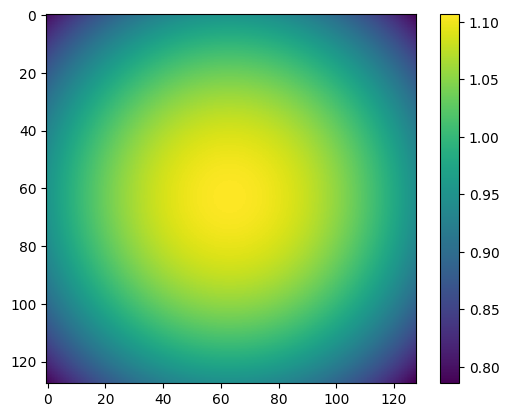

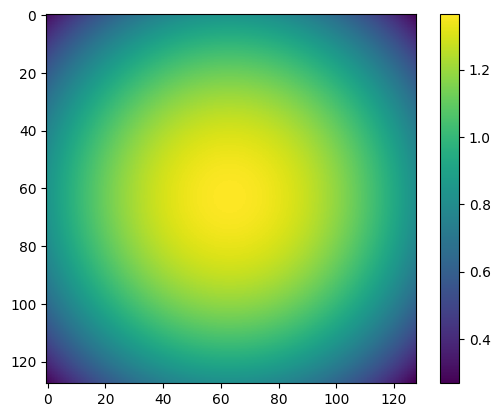

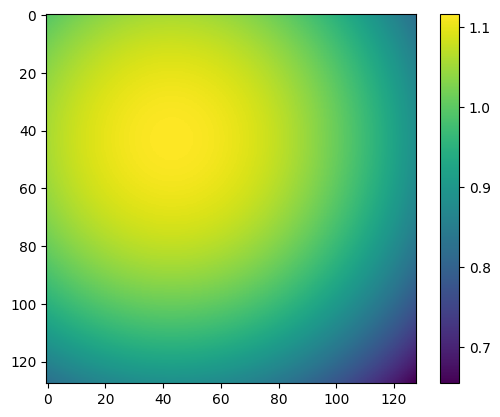

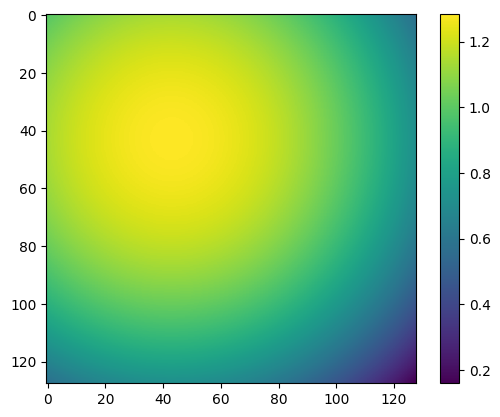

In [8]:
def generate_parabola(dim, coef, center):
    sizes = [128] * dim
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1 - c, size // 2 - c, size)
                for (c, size) in zip(center, sizes)
            ],
            indexing="ij"
        )
    )
    gradient = np.sum(grid**2, axis=0)
    gradient = coef * (np.max(gradient) - gradient) + 10
    return gradient / gradient.mean()


# Ground truth, for correctness checking

params = [
    (2, 0.0005, (0, 0)),
    (2, 0.005, (0, 0)),
    (2, 0.0005, (-20, -20)),
    (2, 0.005, (-20, -20)),
]

flatfield_profiles = [generate_parabola(*ps) for ps in params]

for p in flatfield_profiles:
    plt.imshow(p)
    plt.colorbar()
    plt.show()

# See how random out-of-flatfield objects affect the estimation

aim ... add random (uncorrelated) object that show intensity profile different from the fitted flatfield, see how it affects the fitting quality

## Flatfield only cases

In [9]:
blob_size = 2
blob_dist = lambda: np.random.normal(0, 2)

### single image test 

In [10]:
def generate_cluttered_images(
    true_flatfield, intensity, n_images, ave_count, blob_dist
):
    poss = np.array(
        [
            [
                np.random.uniform(
                    -size // 2 + 1,
                    size // 2,
                )
                for size in true_flatfield.shape
            ]
            for _ in range(np.random.poisson(ave_count))
        ]
    )

    images = []
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1, size // 2, size)
                for size in true_flatfield.shape
            ],
            indexing="ij"
        )
    )
    for _ in range(n_images):
        image = true_flatfield.copy()
        for p in poss:
            image += (
                np.exp(
                    -np.sum((grid - p[:, np.newaxis, np.newaxis]) ** 2, axis=0)
                    / 2.0
                    / blob_size**2
                )
                / np.sqrt(2 * np.pi * blob_size**2) ** 2
                * blob_dist()
            )
        image = image * intensity
        image = np.clip(image, 0, None)
        image = np.random.poisson(image)
        images.append(image)
    return np.array(images)

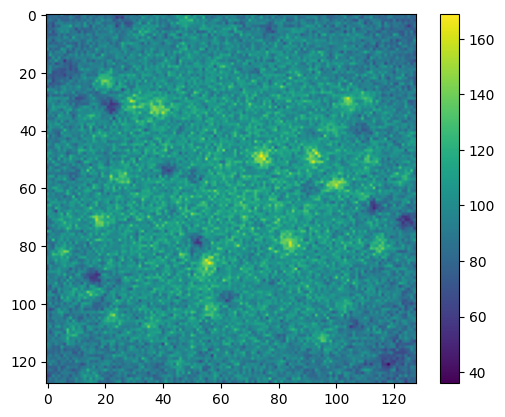

In [11]:
images = generate_cluttered_images(
    flatfield_profiles[0], 100, 100, 100, lambda: np.random.normal(0, 5)
)
plt.imshow(images[0])
plt.colorbar()

/tmp/ipykernel_236582/556527130.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  b.fit(np.array(images))


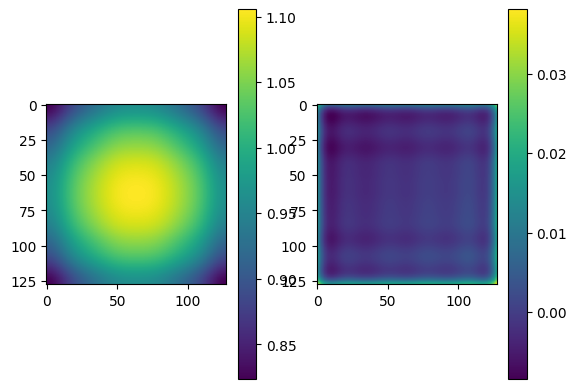

In [12]:
b = BaSiC(get_darkfield=False)
b.fit(np.array(images))
plt.subplot(121)
plt.imshow(b.flatfield)
plt.colorbar()
plt.subplot(122)
plt.imshow(b.flatfield / np.mean(b.flatfield) - flatfield_profiles[0])
plt.colorbar()

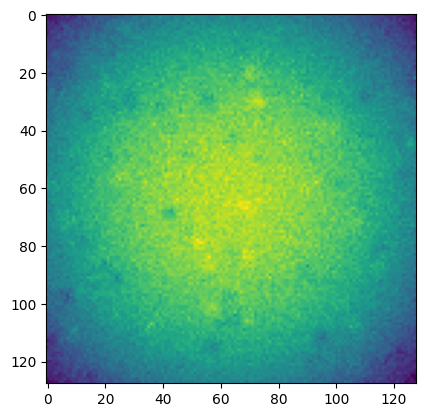

In [14]:
plt.imshow(np.median(images, axis=0))

### fit multiple images 

In [15]:
def fit_and_report(true_flatfield_id,
    intensity,
    ave_count,
    n_images,
    blob_dist_key,
    fitting_mode,
    smoothness_flatfield):
    images = generate_cluttered_images(
        flatfield_profiles[true_flatfield_id],
        intensity=intensity,
        n_images=n_images,
        ave_count=ave_count,
        blob_dist=blob_dists[blob_dist_key],
    )
    b = BaSiC(
        get_darkfield=False,
        fitting_mode=fitting_mode,
        smoothness_flatfield=smoothness_flatfield,
    )
    b.fit(images)
    return b.flatfield

In [16]:
np.random.seed(202306)
repeat = 100
blob_dists = {
    "unbiased": lambda: np.random.normal(0, 5),
    "biased": lambda: np.random.normal(10, 5),
}
conditions = list(
    product(
        range(
            len(flatfield_profiles)
        ),  # true_flatfield_id (index of flatfield_profiles)
        [10, 100, 1000],  # intensity
        [10, 100, 1000],  # ave_count
        [10, 30, 100, 300, 1000],  # n_images
        ["biased", "unbiased"],  # blob_dist_key
        ["ladmap", "approximate"],  # fitting_mode
        list(np.logspace(-3, 1, 15)),  # smoothness_flatfield
    )
)

parameters = []
ress = []
for (
    true_flatfield_id,
    intensity,
    ave_count,
    n_images,
    blob_dist_key,
    fitting_mode,
    smoothness_flatfield,
) in tqdm(conditions):
    p = {
            "true_flatfield_id": true_flatfield_id,
            "intensity": intensity,
            "ave_count": ave_count,
            "n_images": n_images,
            "blob_dist_key": blob_dist_key,
            "fitting_mode": fitting_mode,
            "smoothness_flatfield": smoothness_flatfield,
        }
    parameters.append(
        p
    )
    ress.append(ray.remote(fit_and_report).remote(**p))
    

  2%|█▏                                                                  | 269/15120 [00:01<01:18, 189.63it/s](fit_and_report pid=237167) 2023-06-26 09:29:03.289132: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(fit_and_report pid=237167) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
 10%|███████                                                            | 1583/15120 [00:09<01:26, 156.62it/s](fit_and_report pid=237173) 2023-06-26 09:29:04.122667: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 19x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(fit_and_report pid=237173) No GPU/TPU fou

In [17]:
from tqdm import tqdm
def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])
        
def show_ray_progress(res):
    for x in tqdm(to_iterator(res), total=len(res)):
        pass
    return ray.get(res)

In [18]:
show_ray_progress(ress)

  0%|▎                                                                    | 68/15120 [00:00<01:38, 152.26it/s](fit_and_report pid=237158) Single-step optimization did not converge at the last reweighting step.
(fit_and_report pid=237168) Single-step optimization did not converge at the last reweighting step.
(fit_and_report pid=237176) /tmp/ipykernel_236582/710359529.py:20: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  0%|▎                                                                    | 68/15120 [00:17<01:38, 152.26it/s](fit_and_report pid=237172) /tmp/ipykernel_236582/710359529.py:20: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead. [repeated 2x across cluster]
(fit_and_report pid=237169) Single-step optimization did not converge at the last reweighting step.
(fit_and_report pid=237162) /tmp/ipykernel_236582/710359529.py:20: 

KeyboardInterrupt: 

## Including darkfield